In [23]:
import numpy as np
from scipy.special import expit
import scipy.stats
from randomizedRRR.primal import fit_reduced_rank_regression_tikhonov, fit_rand_reduced_rank_regression_tikhonov
import torch

# I will realize a prototypical low-rank matrix using a sigmoid function
def make_rand_mat(dim, decay_len, rank, seed = None):
    x = np.arange(dim)
    x-= rank
    eigenvalues = expit(-x*6/decay_len)
    U = scipy.stats.special_ortho_group.rvs(dim, random_state=seed)
    return np.linalg.multi_dot([U, np.diag(eigenvalues), U.T])

def make_dataset(mat, num_samples, sigma = 0.1, seed = None):
    dim = mat.shape[0]
    rng = np.random.default_rng(seed)
    X = rng.multivariate_normal(np.zeros(dim), np.eye(dim), size=num_samples)
    Y = (mat@X.T).T + rng.normal(0, sigma, size=(num_samples, dim))
    return X, Y

In [24]:
dim = 100
num_samples = 1000
decay_len = 3
rank = 10

G = make_rand_mat(dim, decay_len, rank, seed = 0)
X, Y = make_dataset(G, num_samples, seed = 0)

In [25]:
C_X = (X.T@X) / num_samples
C_XY = (X.T@Y) / num_samples

In [32]:
reg = 1e-9

U = fit_reduced_rank_regression_tikhonov(torch.from_numpy(C_X),torch.from_numpy(C_XY), reg, rank + 3)

G_hat = np.linalg.multi_dot([U, U.T, C_XY])

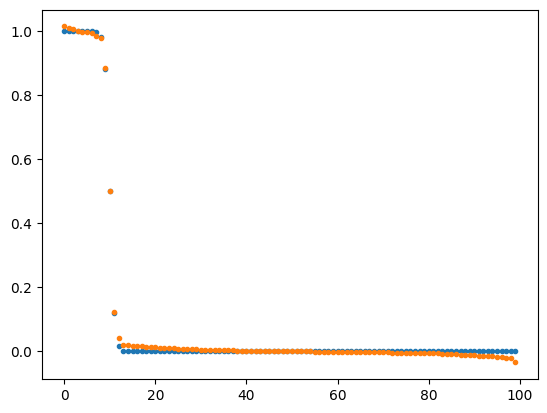

In [33]:
plt.plot(np.flip(np.linalg.eigvalsh(G)), '.', label = 'true eigenvalues')
plt.plot(np.flip(np.linalg.eigvalsh(G_hat)), '.', label = 'estimated eigenvalues')

Things to do:
1. Write a `risk` function (copy from `kooplearn`)
2. Resusciate the statistical error estimators from `randSVD_benchmarks.py`
3. Do an equivalent of figure 1 with an additional panel on timings (and maybe another in eigenvalue estimation, given sharp-spectral rates).